## Amazon Books- Collaborative Filtering

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

#import os
#os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
#os.environ["CUDA_VISIBLE_DEVICES"]="2"

from fastai.learner import *
from fastai.column_data import *

Data available from http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/ratings_Books.csv

In [2]:
path='data/amazonbooks/'

We're working with the movielens data, which contains one rating per row, like this:

In [3]:
ratings = pd.read_csv(path+'ratings_Books.csv')
ratings.head()

,reviewerID,productID,rating,unixReviewTime
0,AH2L9G3DQHHAJ,0000000116,4.0,1019865600
1,A2IIIDRK3PRRZY,0000000116,1.0,1395619200
2,A1TADCM7YWPQ8M,0000000868,4.0,1031702400
3,AWGH7V0BDOJKB,0000013714,4.0,1383177600
4,A3UTQPQPM4TQO0,0000013714,5.0,1374883200


Just for display purposes, let's read in the movie names too.

## Create subset for Excel

We create a crosstab of the most popular movies and most movie-addicted users which we'll copy into Excel for creating a simple example. This isn't necessary for any of the modeling below however.

In [4]:
g=ratings.groupby('reviewerID')['rating'].count()
topReviewers=g.sort_values(ascending=False)[:15]

g=ratings.groupby('productID')['rating'].count()
topProducts=g.sort_values(ascending=False)[:15]

top_r = ratings.join(topReviewers, rsuffix='_r', how='inner', on='reviewerID')
top_r = top_r.join(topProducts, rsuffix='_r', how='inner', on='productID')

pd.crosstab(top_r.reviewerID, top_r.productID, top_r.rating, aggfunc=np.sum)

productID,0007386648,030758836X,0316055433,0375831002,038536315X,0385537859,0399159347,0439023483,0439023513,0849922070
reviewerID,,,,,,,,,,
A13QTZ8CIMHHG4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN
A14OJS0VWMOSWO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0
A1K1JW1C5CUSUZ,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN
A2F6N60Z96CAJI,5.0,5.0,3.0,5.0,5.0,5.0,5.0,NaN,NaN,NaN
A2TX179XAT5GRP,NaN,NaN,NaN,5.0,NaN,NaN,NaN,5.0,5.0,NaN
AFVQZQ8PW0L,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN


## Collaborative filtering

In [5]:
val_idxs = get_cv_idxs(len(ratings))
wd=2.5e-4
n_factors = 25

In [6]:
cf = CollabFilterDataset.from_csv(path, 'ratings_Books.csv', 'reviewerID', 'productID', 'rating')
learn = cf.get_learner(n_factors, val_idxs, 1024000, opt_fn=optim.Adam)
learn.models.model = torch.nn.DataParallel(learn.models.model)

In [7]:
learn.lr_find()

epoch      trn_loss   val_loss                            
    0      2.519549   2.40227   



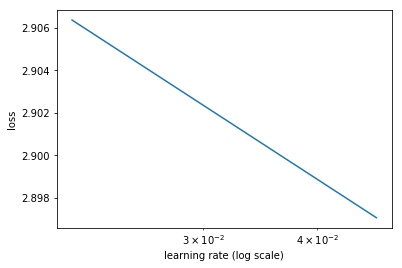

In [8]:
learn.sched.plot()

In [ ]:
learn.fit(0.1, n_cycle=4, wds=wd, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss                            
    0      2.644022   2.629663  
    1      2.641149   2.633412                            
 22%|██▏       | 4/18 [00:40<02:21, 10.13s/it, loss=2.64]

Let's compare to some benchmarks. Here's [some benchmarks](https://www.librec.net/release/v1.3/example.html) on the same dataset for the popular Librec system for collaborative filtering. They show best results based on [RMSE](http://www.statisticshowto.com/rmse/) of 0.91. We'll need to take the square root of our loss, since we use plain MSE.

In [ ]:
math.sqrt(0.776)

Looking good - we've found a solution better than any of those benchmarks! Let's take a look at how the predictions compare to actuals for this model.

In [ ]:
preds = learn.predict()

In [ ]:
y=learn.data.val_y
sns.jointplot(preds, y, kind='hex', stat_func=None);

## Analyze results

### Movie bias

In [ ]:
movie_names = ratings.set_index('productID')['title'].to_dict()
g=ratings.groupby('productID')['rating'].count()
topProducts=g.sort_values(ascending=False).index.values[:3000]
topProductIDx = np.array([cf.item2idx[o] for o in topMovies])

In [ ]:
m=learn.model; m.cuda()

First, we'll look at the movie bias term. Here, our input is the movie id (a single id), and the output is the movie bias (a single float).

In [ ]:
movie_bias = to_np(m.ib(V(topProductIDx)))

In [ ]:
movie_bias

In [ ]:
movie_ratings = [(b[0], movie_names[i]) for i,b in zip(topMovies,movie_bias)]

Now we can look at the top and bottom rated movies. These ratings are corrected for different levels of reviewer sentiment, as well as different types of movies that different reviewers watch.

In [ ]:
sorted(movie_ratings, key=lambda o: o[0])[:15]

In [ ]:
sorted(movie_ratings, key=itemgetter(0))[:15]

In [ ]:
sorted(movie_ratings, key=lambda o: o[0], reverse=True)[:15]

### Embedding interpretation

We can now do the same thing for the embeddings.

In [ ]:
movie_emb = to_np(m.i(V(topProductIDx)))
movie_emb.shape

Because it's hard to interpret 50 embeddings, we use [PCA](https://plot.ly/ipython-notebooks/principal-component-analysis/) to simplify them down to just 3 vectors. 

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
movie_pca = pca.fit(movie_emb.T).components_

In [ ]:
movie_pca.shape

In [ ]:
fac0 = movie_pca[0]
movie_comp = [(f, movie_names[i]) for f,i in zip(fac0, topMovies)]

Here's the 1st component. It seems to be 'easy watching' vs 'serious'.

In [ ]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

In [ ]:
sorted(movie_comp, key=itemgetter(0))[:10]

In [ ]:
fac1 = movie_pca[1]
movie_comp = [(f, movie_names[i]) for f,i in zip(fac1, topMovies)]

Here's the 2nd component. It seems to be 'CGI' vs 'dialog driven'.

In [ ]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

In [ ]:
sorted(movie_comp, key=itemgetter(0))[:10]

We can draw a picture to see how various movies appear on the map of these components. This picture shows the first two components.

In [ ]:
idxs = np.random.choice(len(topMovies), 50, replace=False)
X = fac0[idxs]
Y = fac1[idxs]
plt.figure(figsize=(15,15))
plt.scatter(X, Y)
for i, x, y in zip(topMovies[idxs], X, Y):
    plt.text(x,y,movie_names[i], color=np.random.rand(3)*0.7, fontsize=11)
plt.show()

## Collab filtering from scratch

### Dot product example

In [ ]:
a = T([[1.,2],[3,4]])
b = T([[2.,2],[10,10]])
a,b

In [ ]:
a*b

In [ ]:
(a*b).sum(1)

In [ ]:
class DotProduct(nn.Module):
    def forward(self, u, m): return (u*m).sum(1)

In [ ]:
model=DotProduct()

In [ ]:
model(a,b)

### Dot product model

In [ ]:
u_uniq = ratings.reviewerID.unique()
user2idx = {o:i for i,o in enumerate(u_uniq)}
ratings.reviewerID = ratings.reviewerID.apply(lambda x: user2idx[x])

m_uniq = ratings.productID.unique()
movie2idx = {o:i for i,o in enumerate(m_uniq)}
ratings.productID = ratings.productID.apply(lambda x: movie2idx[x])

n_users=int(ratings.reviewerID.nunique())
n_movies=int(ratings.productID.nunique())

In [ ]:
class EmbeddingDot(nn.Module):
    def __init__(self, n_users, n_movies):
        super().__init__()
        self.u = nn.Embedding(n_users, n_factors)
        self.m = nn.Embedding(n_movies, n_factors)
        self.u.weight.data.uniform_(-0.01,0.01)
        self.m.weight.data.uniform_(-0.01,0.01)
        
    def forward(self, cats, conts):
        users,movies = cats[:,0],cats[:,1]
        u,m = self.u(users),self.m(movies)
        return (u*m).sum(1)

In [ ]:
x = ratings.drop(['rating', 'timestamp'],axis=1)
y = ratings['rating'].astype(np.float32)

In [ ]:
data = ColumnarModelData.from_data_frame(path, val_idxs, x, y, ['reviewerID', 'productID'], 64)

In [ ]:
wd=1e-5
model = EmbeddingDot(n_users, n_movies).cuda()
opt = optim.SGD(model.parameters(), 1e-1, weight_decay=wd, momentum=0.9)

In [ ]:
fit(model, data, 3, opt, F.mse_loss)

In [ ]:
set_lrs(opt, 0.01)

In [ ]:
fit(model, data, 3, opt, F.mse_loss)

### Bias

In [ ]:
min_rating,max_rating = ratings.rating.min(),ratings.rating.max()
min_rating,max_rating

In [ ]:
def get_emb(ni,nf):
    e = nn.Embedding(ni, nf)
    e.weight.data.uniform_(-0.01,0.01)
    return e

class EmbeddingDotBias(nn.Module):
    def __init__(self, n_users, n_movies):
        super().__init__()
        (self.u, self.m, self.ub, self.mb) = [get_emb(*o) for o in [
            (n_users, n_factors), (n_movies, n_factors), (n_users,1), (n_movies,1)
        ]]
        
    def forward(self, cats, conts):
        users,movies = cats[:,0],cats[:,1]
        um = (self.u(users)* self.m(movies)).sum(1)
        res = um + self.ub(users).squeeze() + self.mb(movies).squeeze()
        res = F.sigmoid(res) * (max_rating-min_rating) + min_rating
        return res

In [ ]:
wd=2e-4
model = EmbeddingDotBias(cf.n_users, cf.n_items).cuda()
opt = optim.SGD(model.parameters(), 1e-1, weight_decay=wd, momentum=0.9)

In [ ]:
fit(model, data, 3, opt, F.mse_loss)

In [ ]:
set_lrs(opt, 1e-2)

In [ ]:
fit(model, data, 3, opt, F.mse_loss)

### Mini net

In [ ]:
class EmbeddingNet(nn.Module):
    def __init__(self, n_users, n_movies, nh=10, p1=0.05, p2=0.5):
        super().__init__()
        (self.u, self.m) = [get_emb(*o) for o in [
            (n_users, n_factors), (n_movies, n_factors)]]
        self.lin1 = nn.Linear(n_factors*2, nh)
        self.lin2 = nn.Linear(nh, 1)
        self.drop1 = nn.Dropout(p1)
        self.drop2 = nn.Dropout(p2)
        
    def forward(self, cats, conts):
        users,movies = cats[:,0],cats[:,1]
        x = self.drop1(torch.cat([self.u(users),self.m(movies)], dim=1))
        x = self.drop2(F.relu(self.lin1(x)))
        return F.sigmoid(self.lin2(x)) * (max_rating-min_rating+1) + min_rating-0.5

In [ ]:
wd=1e-5
model = EmbeddingNet(n_users, n_movies).cuda()
opt = optim.Adamax()
opt = optim.Adam(model.parameters(), 1e-3, weight_decay=wd)

In [ ]:
fit(model, data, 3, opt, F.mse_loss)

In [ ]:
set_lrs(opt, 1e-3)

In [ ]:
fit(model, data, 3, opt, F.mse_loss)